# Assignment 2 - Damir Nabiullin
d.nabiullin@innopolis.university

# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

In [1]:
# Imports for all tasks
import os
import time
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import operator

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from torchvision import transforms
from torchvision.datasets import ImageFolder

C:\Users\Dale\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

# TASK 1 - SOLUTION

## Import dataset

In [2]:
# Read data set
data = pd.read_csv('Task 1.csv')
print(data.shape)
data.head()

(1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


## Check columns and prepare them for encoding

In [3]:
# Check count of distinct values in columns gender, lunch
gender_col = data['gender'].unique()
print(data['gender'].nunique(), gender_col)

lunch_col = data['lunch'].unique()
print(data['lunch'].nunique(), lunch_col)

course_col = data['test preparation course'].unique()
print(data['test preparation course'].nunique(), course_col)

race_col = data['race/ethnicity'].unique()
race_col.sort()
print(data['race/ethnicity'].nunique(), race_col)

level_col = data['parental level of education'].unique()
print(data['parental level of education'].nunique(), level_col)

# Array of orginized parental level of education
level_col = ['some high school', 'high school', 'some college', 'associate\'s degree', 'bachelor\'s degree', 'master\'s degree']

print('\nOrginized parental level of education: ', level_col)

2 ['male' 'female']
2 ['standard' 'free/reduced']
2 ['completed' 'none']
5 ['group A' 'group B' 'group C' 'group D' 'group E']
6 ['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]

Orginized parental level of education:  ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]


## Encode columns

In [4]:
# Create encoder
ordinalEncoder = OrdinalEncoder(categories=[race_col, level_col])
oneHotEncoder = OneHotEncoder()

ordinal_features = ['race/ethnicity', 'parental level of education']
one_hot_features = ['gender', 'lunch', 'test preparation course']

In [5]:
# Encode ordinal features
new_oe_features = ordinalEncoder.fit_transform(data[ordinal_features])
new_oe_cols = pd.DataFrame(new_oe_features, dtype=int, columns=ordinal_features)

In [6]:
# Encode one hot features
new_ohe_features = oneHotEncoder.fit_transform(data[one_hot_features])
new_ohe_cols = pd.DataFrame(new_ohe_features.toarray(), dtype=int, columns=oneHotEncoder.get_feature_names(one_hot_features))

C:\Users\Dale\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Combine new columns into new dataset

In [7]:
# Combine all features
new_data = pd.concat([data], axis=1)
new_data = new_data.drop(columns=ordinal_features + one_hot_features )
new_data = pd.concat([new_data, new_oe_cols, new_ohe_cols], axis=1)
new_data.head()

,math score,reading score,writing score,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,67,67,63,0,1,0,1,0,1,1,0
1,40,59,55,3,0,1,0,1,0,0,1
2,59,60,50,4,2,0,1,1,0,0,1
3,77,78,68,1,1,0,1,0,1,0,1
4,78,73,68,4,3,0,1,0,1,1,0


## Split dataset

In [8]:
# Split data to target and features
X = new_data.iloc[:, 3:].values
y = new_data.iloc[:, :3].values

# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Scale features

In [9]:
# Scale testing and training data
scaler = StandardScaler()
scaler.fit(X_train)

# Create Data Frames with scaled data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# # Scale target data
# target_scaler = StandardScaler()
# target_scaler.fit(y_train)

# # Create Data Frames with scaled data
# y_train = target_scaler.transform(y_train)
# y_test = target_scaler.transform(y_test)

## Create custom dataset for pytorch

In [11]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [12]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

In [13]:
data, label = next(iter(train_dataloader))
label.shape

torch.Size([32, 3])

## Create ANN model and prepare device

In [14]:
use_cuda = torch.cuda.is_available()
print("cuda" if use_cuda else "cpu")
device = torch.device("cuda" if use_cuda else "cpu")

cuda


In [15]:
# Custom neural network class
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.hidden1 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 3)

    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))
        x = self.output(x)
        return x

# Create neural network
model = ANN().to(device)

print(model)

ANN(
  (hidden1): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)


In [16]:
epochs = 100
lr = 0.001
momentum = 0.9
seed = 1
log_interval = 4

loss_fn = nn.MSELoss(reduction='mean')

## Create functions for accuracy and debug

In [17]:
# Function to compare first element in batch with the first target value 
def print_batch_element_error(batch, target):
    # get value from tensor
    batch = batch.cpu().data.numpy()
    target = target.cpu().data.numpy()
    # get first element from batch
    predicted_v = batch[0]
    target_v = target[0]
    # print error
    error = np.abs(predicted_v - target_v)
    print('Predicted: ', predicted_v, 'Target: ', target_v, 'Error: ', error, '\n')


# Custom accuracy function
def task1_accuracy(output, target, threshold=2):
    # get value from tensor
    output = output.cpu().data.numpy()
    target = target.cpu().data.numpy()
    accuracy = 0
    for i in range(len(output)):
        predicted_v = output[i]
        target_v = target[i]
        error = np.abs(predicted_v - target_v)
        for j in range(len(error)):
            if error[j] <= threshold:
                error[j] = 1
            else:
                error[j] = 0
        accuracy += np.sum(error)/3
    
    return accuracy/len(output)

## Prepare EarlyStopping

In [18]:
# Based on https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
# And Lab_10
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        # Set initial values
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf

        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric):
        # Calculate difference between current metric and previous metric
        delta = (metric - self.prev_metric)

        # Check if difference is greater than minimum delta
        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        # Check if counter is greater than tolerance
        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

## Function to train model

In [19]:
def train(model, device, train_loader, optimizer, epoch, loss_func, accuracy_func = None, task = 1):
    model.train()
    epoch_loss = 0
    accuracy = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data).squeeze()

        # Calculate loss
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate accuracy
        if accuracy_func:
            curr_accuracy = accuracy_func(output, target)
            accuracy += curr_accuracy

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()), end='')
            # Print accuracy if accuracy function is provided
            if accuracy_func:
                print('\tAccuracy: {:.6f}'.format(curr_accuracy), end='')
            print()

    # Calculate average loss
    if task == 1:
        epoch_loss /= len(train_loader.dataset)
    elif task == 2:
        epoch_loss /= len(train_loader)

    # Print average scores for epoch
    print('\nTrain Epoch: Average Loss: {:.6f}'.format(epoch_loss), 
          end='')
    
    if accuracy_func:
        print('\tAverage Accuracy: {:.6f}'.format(accuracy/len(train_loader)), 
               end='')
    print()

## Function to test/validate model

In [20]:
def test(model, device, test_loader, loss_func, accuracy_func, task = 1, set_name = 'Test'):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Get data and target
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            # Calculate loss
            test_loss += loss_func(output, target).item()
            # Calculate accuracy
            accuracy += accuracy_func(output, target)

    # Calculate average loss
    if task == 1:
        test_loss /= len(test_loader.dataset)
    elif task == 2:
        test_loss /= len(test_loader)
    
    # Print average scores
    print('\n{} set: Average loss: {:.4f} Average accuracy: {:.4f}\n'.format(
           set_name, 
           test_loss, 
           accuracy / len(test_loader)))

    return test_loss

## Train and test ANN model

In [21]:
optimizer = optim.SGD(model.parameters(), 
                      lr=lr, 
                      momentum=momentum)
                      
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    # Train
    train(model, 
          device, 
          train_dataloader, 
          optimizer, 
          epoch, 
          loss_fn, 
          task1_accuracy)

    # Test
    test_loss = test(model, 
                     device, 
                     test_dataloader, 
                     loss_fn, 
                     task1_accuracy)

    if early_stopping(test_loss):
        break

Train Epoch: 1 [0/800 (0%)]	Loss: 4121.333984	Accuracy: 0.000000
Train Epoch: 1 [128/800 (16%)]	Loss: 4676.283203	Accuracy: 0.000000
Train Epoch: 1 [256/800 (32%)]	Loss: 4269.596680	Accuracy: 0.000000
Train Epoch: 1 [384/800 (48%)]	Loss: 3870.515137	Accuracy: 0.000000
Train Epoch: 1 [512/800 (64%)]	Loss: 1508.657227	Accuracy: 0.000000
Train Epoch: 1 [640/800 (80%)]	Loss: 1083.538086	Accuracy: 0.000000
Train Epoch: 1 [768/800 (96%)]	Loss: 314.277649	Accuracy: 0.104167

Train Epoch: Average Loss: 92.929020	Average Accuracy: 0.012917

Test set: Average loss: 7.8258 Average accuracy: 0.1116

Train Epoch: 2 [0/800 (0%)]	Loss: 278.621887	Accuracy: 0.062500
Train Epoch: 2 [128/800 (16%)]	Loss: 638.182739	Accuracy: 0.031250
Train Epoch: 2 [256/800 (32%)]	Loss: 691.112000	Accuracy: 0.052083
Train Epoch: 2 [384/800 (48%)]	Loss: 525.589294	Accuracy: 0.062500
Train Epoch: 2 [512/800 (64%)]	Loss: 308.343445	Accuracy: 0.041667
Train Epoch: 2 [640/800 (80%)]	Loss: 368.728241	Accuracy: 0.104167
Train 

# Answers

1. What preprocessing techniques did you use? Why?

    - Firstly, I prepared columns for encoding. I sorted columns that I decided encode with ordinal encoding.
    
    - In this task I used both One-Hot and Ordinal encoding techniques. One-Hot encoding I used for columns that have only 2 unique values. Ordinal encoding I used for ordinal values as parental level of education and race (I decided that this columns has some order).
    
    - After encoding I normalized features. I did to improve speed of education and prediction (as we disscussed on labs). 

2. Describe the fine-tuning process and how you reached your model architecture.

    - Firstly, I understood that this target weakly connected with features. Therefore, when I tried to increase the output number of input layer - I got very big loss values.

    - Moreover, I tried different number of layers (2, 3, and 4). When I used more than 2 layers, my loss encreased. I think, this happens because of weak connection between features and target, and more neurons creates more variability.

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

# TASK 2 - SOLUTION

## Data preprocessing and augmentation

In this task I used such data preprocessing methods and augmentation:

1) Resize - I used it to don't care about the initial size of image and work with concrete one.

2) Grayscale - I used it to work with one input channel, as our image is consist of black and white colors. In this case I decided that RGB is unnecessary.

3) ToTensor - transform PIL to Tensor

4) Moreover, I apply RandomRotation for training set. This can be useful in cases where the handwriting is slightly slanted.

In [22]:
# Paths to data
test_path = './triple_mnist/triple_mnist/test/'
train_path = './triple_mnist/triple_mnist/train/'
val_path = './triple_mnist/triple_mnist/val/'

batch_size = 64

# Define train transforms
train_transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.Grayscale(),
    transforms.RandomRotation(degrees=(-7, 7)),
    transforms.ToTensor()
])

# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load train, test and validation datasets
train_data = ImageFolder(root=train_path, 
                         transform=test_transform)

augumented_train_data = ImageFolder(root=train_path,
                                    transform=train_transform)

test_data = ImageFolder(root=test_path, 
                        transform=test_transform)
                        
val_data = ImageFolder(root=val_path, 
                       transform=test_transform)

In this part I decide to fix labels (targets column) in the dataset. ImageFolder readed it in this case: (path_to_image, index_of_class). I changed it to this way: (path_to_image, [num1, num2, num3]).

I made it to predict each digit separately and improve time perfomance. I think that this way is better than predict 1 out of 1000 classes.

In [23]:
# Function to fix target values in dataset
def fix_data_targets(data):
    classes = data.classes
    for i in range(len(data.samples)):
        path, index = data.samples[i]
        cl = classes[index]
        arr = np.zeros((3,), dtype=np.int64)
        for j in range(len(cl)):
            arr[j] = int(cl[j])
        new_sample = (path, arr)
        data.samples[i] = new_sample
        data.targets[i] = arr

In [24]:
# Apply fix_data_targets to all datasets
fix_data_targets(train_data)
fix_data_targets(test_data)
fix_data_targets(val_data)
fix_data_targets(augumented_train_data)

train_data.samples

[('./triple_mnist/triple_mnist/train/000\\0_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\10_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\11_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\12_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\13_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\14_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\15_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\16_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\17_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\18_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/triple_mnist/train/000\\19_000.png',
  array([0, 0, 0], dtype=int64)),
 ('./triple_mnist/trip

In [25]:
# Combine train and augumented datasets
print('Train data size: {}'.format(len(train_data)))
train_data = ConcatDataset([train_data, augumented_train_data])
print('Train data size: {}'.format(len(train_data)))

Train data size: 64000
Train data size: 128000


In [26]:
# Load data
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

## Show one sample from dataset

In this part I get number of input channels and show first image from batch

torch.Size([64, 1, 84, 84]) 7056 1


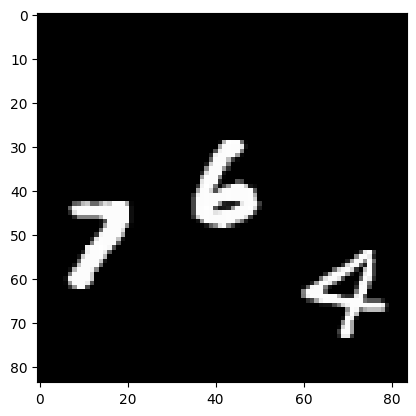

In [27]:
images, labels = next(iter(train_loader))

# in_channels is created for future use in CNN
in_channels = images.shape[1]
images_shape = np.prod(images.shape[1:])

# Plot imahe and print shape
print(images.shape, images_shape, in_channels)
plt.imshow(np.transpose(images[0].cpu().detach().numpy(), (1, 2, 0)), cmap='gray')

## Prepare ANN from the first task for new data

In [28]:
class ANN_2(ANN):
    def __init__(self):
        super(ANN_2, self).__init__()
        self.hidden1 = nn.Linear(images_shape, 64)
        self.output = nn.Linear(64, 30)
        
    def forward(self, x):
        # Reshape input
        x = x.view(-1, images_shape)

        # Apply first hidden layer
        x = F.leaky_relu(self.hidden1(x))

        # Apply output layer
        x = self.output(x)
        
        # Apply softmax
        x = F.log_softmax(x, dim=1)

        # Reshape output
        x = x.view(-1, 3, 10)
        # Transpose output for loss function
        x = x.transpose(1, 2)

        return x

In [29]:
ann_model = ANN_2().to(device)
print(ann_model)

ANN_2(
  (hidden1): Linear(in_features=7056, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=30, bias=True)
)


## Update epochs number and loss function

In this task I decide to check ANN model without changing learning rate and momentum. As we asked to change only input and output layers.

Moreover, I tried 2 different loss functions: NLLLoss and CrossEntropyLoss. As for me, in this case NLLLoss was better and model trained a little bit better.

In [30]:
epochs = 10
log_interval = 80

loss_fn = nn.NLLLoss()
# loss_fn = nn.CrossEntropyLoss()

## Create a custom function for accuracy

In [31]:
def task2_accuracy(output, target):
    # Convert Test data to numpy
    output = output.cpu().detach().numpy()
    target = target.cpu().detach().numpy()

    accuracy = 0

    # Itterate through each batch element
    for i in range(len(output)):
        out = np.transpose(output[i])
        tar = target[i]

        num1 = out[0].argmax()
        num2 = out[1].argmax()
        num3 = out[2].argmax()

        # print(num1, num2, num3)

        if num1 == tar[0] and num2 == tar[1] and num3 == tar[2]:
            accuracy += 1
    
    return accuracy / len(output)

## Train, validate and test ANN model

In [32]:
optimizer = optim.SGD(ann_model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(ann_model, device, train_loader, optimizer, epoch, loss_fn, None, 2)
    val_loss = test(ann_model, device, val_loader, loss_fn, task2_accuracy, 2, 'Validation')

    if early_stopping(val_loss):
        break

Train Epoch: 1 [0/128000 (0%)]	Loss: 3.400404
Train Epoch: 1 [1280/128000 (1%)]	Loss: 3.408949
Train Epoch: 1 [2560/128000 (2%)]	Loss: 3.393213
Train Epoch: 1 [3840/128000 (3%)]	Loss: 3.410282
Train Epoch: 1 [5120/128000 (4%)]	Loss: 3.403850
Train Epoch: 1 [6400/128000 (5%)]	Loss: 3.404799
Train Epoch: 1 [7680/128000 (6%)]	Loss: 3.392374
Train Epoch: 1 [8960/128000 (7%)]	Loss: 3.392983
Train Epoch: 1 [10240/128000 (8%)]	Loss: 3.399204
Train Epoch: 1 [11520/128000 (9%)]	Loss: 3.393708
Train Epoch: 1 [12800/128000 (10%)]	Loss: 3.393225
Train Epoch: 1 [14080/128000 (11%)]	Loss: 3.390369
Train Epoch: 1 [15360/128000 (12%)]	Loss: 3.394684
Train Epoch: 1 [16640/128000 (13%)]	Loss: 3.390306
Train Epoch: 1 [17920/128000 (14%)]	Loss: 3.387965
Train Epoch: 1 [19200/128000 (15%)]	Loss: 3.398750
Train Epoch: 1 [20480/128000 (16%)]	Loss: 3.390779
Train Epoch: 1 [21760/128000 (17%)]	Loss: 3.390788
Train Epoch: 1 [23040/128000 (18%)]	Loss: 3.393136
Train Epoch: 1 [24320/128000 (19%)]	Loss: 3.387475
T

In [33]:
start_time = time.time()
test_loss = test(ann_model, device, test_loader, loss_fn, task2_accuracy, 2)

print('ANN test seconds: {:.4f}'.format(time.time() - start_time))


Test set: Average loss: 2.8767 Average accuracy: 0.0543

ANN test seconds: 9.8676


## Create a CNN model

For CNN model I tried different functions and number of neurones. I tried:

1) Don't use pool between normalization and convolution -> caused overfitting.

2) To use 2 convolution layers instead of 3 -> caused overfitting.

3) To use 2 linear layers instead of 3 linear layers ->  2 layers showed better result than 3 layers.

4) To use 4 linear layers instead of 3 linear layers -> caused underfitting.

5) To use dropout of 15% on the first linear layer -> caused underfitting.

6) To use small number of output channels (2-3-4) and big numbers (10-16-22) -> with big numbers model worked better

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input image 84 x 84
        self.conv1 = nn.Conv2d(in_channels, 10, 3)  # output 82 x 82
        self.pool = nn.MaxPool2d(2, 2)  # pool function with kernel size 2 and stride 2
        self.conv1_bn = nn.BatchNorm2d(10) # batch normalization for 41 x 41 x 6

        self.conv2 = nn.Conv2d(10, 16, 4)  # output 38 x 38
        self.conv2_bn = nn.BatchNorm2d(16)  # batch normalization for 19 x 19 x 8

        self.conv3 = nn.Conv2d(16, 22, 3) # output 17 x 17
        self.conv3_bn = nn.BatchNorm2d(22) # batch normalization for 17 x 17 x 10

        # self.dropout = nn.Dropout(0.2)

        self.linear1 = nn.Linear(17 * 17 * 22, 128)
        self.out = nn.Linear(128, 30)

    def forward(self, x):
        # Apply first convolutional layer
        x = F.relu(self.conv1(x))
        # Apply pool function
        x = self.pool(x)
        # Apply first batch normalization
        x = self.conv1_bn(x)

        # Apply second convolutional layer
        x = F.relu(self.conv2(x))
        # Apply pool function
        x = self.pool(x)
        # Apply second batch normalization
        x = self.conv2_bn(x)
        
        # Apply third convolutional layer
        x = F.relu(self.conv3(x))
        # Apply batch normalization
        x = self.conv3_bn(x)

        # Flatten the output
        x = torch.flatten(x, 1)
        # Apply first linear layer
        x = F.relu(self.linear1(x))
        
        # # Apply dropout
        # x = self.dropout(x)

        # Apply output layer
        x = self.out(x)

        # Apply softmax function
        x = F.log_softmax(x, dim=1)
        
        # Reshape the output
        x = x.view(-1, 3, 10)
        # Transpose output for loss function
        x = x.transpose(1, 2)
        
        return x

Here I found that learning rate and momentum from first task were bad for CNN, when tested. Therefore, I decided to change it.

In [35]:
lr = 0.01
momentum = 0.5

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 22, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=6358, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=30, bias=True)
)


## Train, validate and test CNN model

In [36]:
optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(cnn_model, device, train_loader, optimizer, epoch, loss_fn, None, 2)
    val_loss = test(cnn_model, device, val_loader, loss_fn, task2_accuracy, 2, 'Validation')

    if early_stopping(val_loss):
        break

Train Epoch: 1 [0/128000 (0%)]	Loss: 3.423158
Train Epoch: 1 [1280/128000 (1%)]	Loss: 3.385986
Train Epoch: 1 [2560/128000 (2%)]	Loss: 3.350809
Train Epoch: 1 [3840/128000 (3%)]	Loss: 3.339273
Train Epoch: 1 [5120/128000 (4%)]	Loss: 3.233303
Train Epoch: 1 [6400/128000 (5%)]	Loss: 3.100366
Train Epoch: 1 [7680/128000 (6%)]	Loss: 3.079088
Train Epoch: 1 [8960/128000 (7%)]	Loss: 2.960394
Train Epoch: 1 [10240/128000 (8%)]	Loss: 2.773672
Train Epoch: 1 [11520/128000 (9%)]	Loss: 2.687652
Train Epoch: 1 [12800/128000 (10%)]	Loss: 2.664328
Train Epoch: 1 [14080/128000 (11%)]	Loss: 2.416240
Train Epoch: 1 [15360/128000 (12%)]	Loss: 2.357264
Train Epoch: 1 [16640/128000 (13%)]	Loss: 2.413530
Train Epoch: 1 [17920/128000 (14%)]	Loss: 2.359674
Train Epoch: 1 [19200/128000 (15%)]	Loss: 2.340583
Train Epoch: 1 [20480/128000 (16%)]	Loss: 2.257724
Train Epoch: 1 [21760/128000 (17%)]	Loss: 2.123961
Train Epoch: 1 [23040/128000 (18%)]	Loss: 2.095608
Train Epoch: 1 [24320/128000 (19%)]	Loss: 2.017122
T

In [37]:
start_time = time.time()
test_loss = test(cnn_model, device, test_loader, loss_fn, task2_accuracy, 2)

print('CNN test seconds: {:.4f}'.format(time.time() - start_time))


Test set: Average loss: 1.2525 Average accuracy: 0.9487

CNN test seconds: 10.0515


## Compare accuracy

Accuracy of ANN model is less than 5%. 

While accuracy of CNN model is close to 90%.

## Compare number of parameters

In [38]:
# Calculate the number of parameters in each model
ann_params = sum(param.numel() for param in ann_model.parameters())
cnn_params = sum(param.numel() for param in cnn_model.parameters())

# Print the number of parameters in each model
print('ANN Parameters: ', ann_params)
print('CNN Parameters: ', cnn_params)

ANN Parameters:  453598
CNN Parameters:  823784


ANN model have 2 times less parameters than CNN model.

## Compare test time

ANN model takes about 7 seconds to predict values on test set.

While CNN model takes about 10 seconds to predict values on test set.

## Answers

In this task I decided to predict each digit of number. Therefore, I have output layer as 30 x 1 in models. Each 10 values - probabilities of digit. Therefore, I split this list into 3 list with 10 values and take the index of maxprobability in each list. Then cobmine and get predicted integer.

1. What preprocessing techniques did you use? Why?
    - In this task I used Resize and Grayscale. I decided to use such preprocessing techniques to ensure that all images in dataset will be 84x84 pixels. Moreover, grayscale is used to change RGB to gray map. I think, that 1 channel input in this task is better than 3 channels.

2. What data augmentation techniques did you use?
    - In this task I used RandomRotation. I tought, that some rotations can improve perfomance in case of different handwritings. Because different handwritings have different slopes.

3. Describe the fine-tuning process and how you reached your final CNN model.
    - For CNN model I tried different functions and number of neurones. I tried:
        1) Don't use pool between normalization and convolution -> caused overfitting.
        2) To use 2 convolution layers instead of 3 -> caused overfitting.
        3) To use 2 linear layers instead of 3 linear layers ->  2 layers showed better result than 3 layers.
        4) To use 4 linear layers instead of 3 linear layers -> caused underfitting.
        5) To use dropout of 15% on the first linear layer -> caused underfitting.
        6) To use small number of output channels (2-3-4) and big numbers (10-16-22) -> with big numbers model worked better

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [39]:
# TODO: Implement task 3

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [40]:
image_paths = []
targets = []
 
# get the path/directory
folder_dir = './svhn/svhn/'
for image in os.listdir(folder_dir):
    # Combine the path and the image name
    image_path = os.path.join(folder_dir, image)
    # get the image name without the extension
    image_name = os.path.splitext(image)[0]
    arr = np.zeros(3, dtype=np.int64)
    arr[0] = int(image_name[0])
    arr[1] = int(image_name[1])
    arr[2] = int(image_name[2])
    image_paths.append(image_path)
    targets.append(arr)

print(image_paths, end='\n\n')
print(*targets, end='\n\n')
print(len(image_paths), len(targets))

['./svhn/svhn/111.png', './svhn/svhn/113.png', './svhn/svhn/114.png', './svhn/svhn/116.png', './svhn/svhn/120.png', './svhn/svhn/124.png', './svhn/svhn/128.png', './svhn/svhn/129.png', './svhn/svhn/130.png', './svhn/svhn/132.png', './svhn/svhn/136.png', './svhn/svhn/138.png', './svhn/svhn/140.png', './svhn/svhn/144.png', './svhn/svhn/148.png', './svhn/svhn/150.png', './svhn/svhn/151.png', './svhn/svhn/153.png', './svhn/svhn/157.png', './svhn/svhn/158.png', './svhn/svhn/159.png', './svhn/svhn/164.png', './svhn/svhn/165.png', './svhn/svhn/166.png', './svhn/svhn/171.png', './svhn/svhn/174.png', './svhn/svhn/176.png', './svhn/svhn/178.png', './svhn/svhn/187.png', './svhn/svhn/188.png', './svhn/svhn/191.png', './svhn/svhn/193.png', './svhn/svhn/195.png', './svhn/svhn/200.png', './svhn/svhn/203.png', './svhn/svhn/204.png', './svhn/svhn/205.png', './svhn/svhn/208.png', './svhn/svhn/209.png', './svhn/svhn/215.png', './svhn/svhn/218.png', './svhn/svhn/220.png', './svhn/svhn/222.png', './svhn/sv

In [41]:
# https://pytorch.org/vision/main/_modules/torchvision/datasets/folder.html

def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

In [42]:
# Custom dataset class
class CustomSVHNDataset(Dataset):
    def __init__(self, paths, targets, transform):
        super().__init__()
        self.paths = paths
        self.targets = torch.tensor(targets).long()
        self.transform = transform

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = pil_loader(self.paths[idx])
        image = self.transform(image)
        target = self.targets[idx]
        return image, target

In [43]:
loss_fn = nn.NLLLoss()
batch_size = 4

# Define train transforms
transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [44]:
data_dataset = CustomSVHNDataset(image_paths, targets, transform)

data_dataloader = DataLoader(data_dataset, batch_size, shuffle=False)

C:\Users\Dale\AppData\Local\Temp\ipykernel_31340\4075927160.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  self.targets = torch.tensor(targets).long()


torch.Size([4, 1, 84, 84]) 7056 1


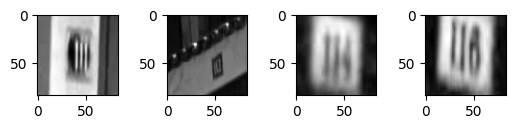

In [45]:
images, labels = next(iter(data_dataloader))

# in_channels is created for future use in CNN
in_channels = images.shape[1]
images_shape = np.prod(images.shape[1:])

# Plot imahe and print shape
print(images.shape, images_shape, in_channels)

for i in range(len(images)):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
plt.show()

In [46]:
loss = test(cnn_model, device, data_dataloader, loss_fn, task2_accuracy, 2)


Test set: Average loss: 8.6822 Average accuracy: 0.0000



8.68217480700949

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*